## Check how charge throughput is affected by save_as_cycles

In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

In [2]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

BasicPath =  os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * # directly do this for HPC

In [3]:
model = pb.lithium_ion.DFN()
T_All = [25]
Para_All = []
for T in T_All:
    param = pb.ParameterValues("OKane2023")
    para_dict = {
        "Negative electrode diffusivity [m2.s-1]":3.3e-14,
        "Positive electrode diffusivity [m2.s-1]":4e-15,
    }
    for key, value in para_dict.items():
        param.update({key: value})
    param.update({'Ambient temperature [K]': T+273.15})
    Para_All.append(param)
V_max = 4.2;        V_min = 2.5; Update_Cycles = [1,10]
discharge_time_mins = 0.15* 60 * 4.86491/5
charge_time_mins = 0.5* 60 * 4.86491/5
exp_AGE_text = [ (
    f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
    f"Charge at 0.3C for {charge_time_mins} minutes or until {V_max}V", 
    ) ] 
Experiment_Long   = pb.Experiment( exp_AGE_text * 10  )
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 20,  # positive particle
}


In [4]:
# CasadiSolver
Sol = []
for update_Cycle in Update_Cycles:
    sim = pb.Simulation(
        model, 
        experiment=Experiment_Long,
        parameter_values=param,
        solver=pb.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts, )
    sol = sim.solve(
        calc_esoh=False,
        save_at_cycles = update_Cycle,)
    Sol.append(sol)

14.381651547421372 14.381651547421345
19.140994331531758 19.140994331531775


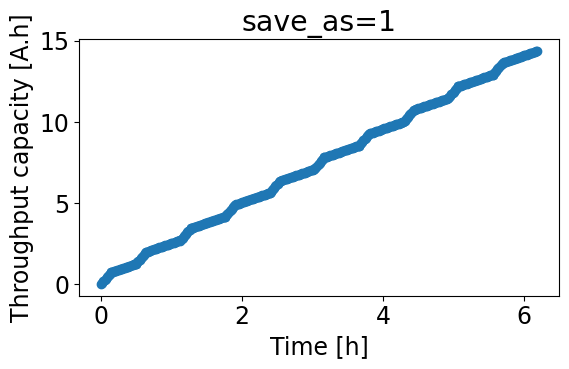

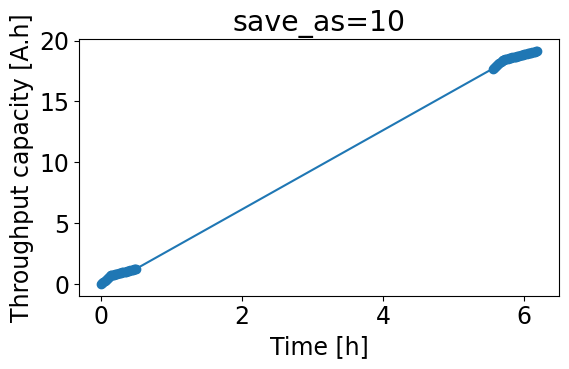

In [7]:
def Plot_sol(sol,title):
    # step-1: get and plot discharge capacity vs throughput capacity 
    fig, axs = plt.subplots( figsize=(6,4),tight_layout=True) 
    #axs.plot(sol["Time [h]"].entries,sol["Discharge capacity [A.h]"].entries,'-o')
    axs.plot(sol["Time [h]"].entries,sol["Throughput capacity [A.h]"].entries-sol["Throughput capacity [A.h]"].entries[0],'-o')
    thr_cap_1 = sol["Throughput capacity [A.h]"].entries[-1]-sol["Throughput capacity [A.h]"].entries[0]
    thr_cap_2 = np.trapz(abs(sol["Current [A]"].entries), sol["Time [h]"].entries) # in A.h
    axs.set_title(title)
    axs.set_xlabel("Time [h]")
    axs.set_ylabel("Throughput capacity [A.h]")
    print(thr_cap_1,thr_cap_2)
    return thr_cap_1,thr_cap_2
thr_cap_1,thr_cap_2 = Plot_sol(Sol[0],f"save_as={Update_Cycles[0]}")
thr_cap_3,thr_cap_4 = Plot_sol(Sol[1],f"save_as={Update_Cycles[1]}")
# 

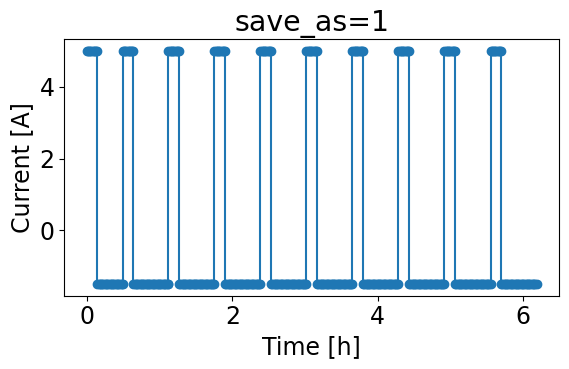

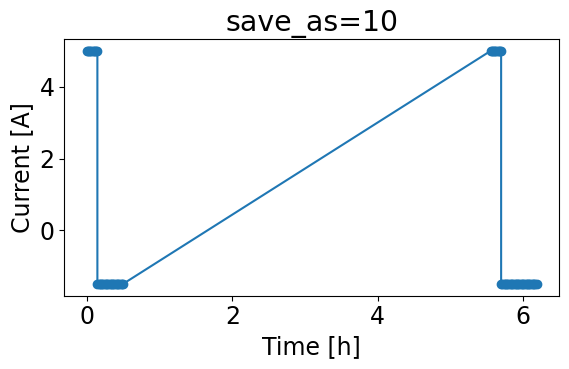

In [9]:
def Plot_cur(sol,title):
    # step-1: get and plot discharge capacity vs throughput capacity 
    fig, axs = plt.subplots( figsize=(6,4),tight_layout=True) 
    #axs.plot(sol["Time [h]"].entries,sol["Discharge capacity [A.h]"].entries,'-o')
    axs.plot(sol["Time [h]"].entries,sol["Current [A]"].entries,'-o')
    axs.set_title(title)
    axs.set_xlabel("Time [h]")
    axs.set_ylabel("Current [A]")
    return 
Plot_cur(Sol[0],f"save_as={Update_Cycles[0]}")
Plot_cur(Sol[1],f"save_as={Update_Cycles[1]}")

In [29]:
# check experiment protocols:
exp_RPT_text = [ (
    # refill
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)",
    # 0.5C cycle 
    f"Discharge at 0.5C until {V_min} V (6 minute period)",  
    "Rest for 3 hours (20 minute period)",
    f"Charge at 0.5C until {V_max} V (6 minute period)",
    # top up to 100%SOC
    f"Hold at {V_max}V until C/100",
    "Rest for 3 hours (20 minute period)",  
    ) ] 
exp2_refill = [ (
    # refill and adjust to target SOC!!!
    f"Charge at 0.3C until {V_max}V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)", 
    # adjust to target SOC, SOC before this step must be 100%
    f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", # discharge for 15%SOC
    "Rest for 3 hours (20 minute period)", 
    ) ] 
exp2_topup = [ (
    # refill and adjust to target SOC!!!
    f"Charge at 0.3C until {V_max}V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)", 
    ) ] 
exp_RPT_GITT_text = [ (
    "Rest for 5 minutes (1 minute period)",  
    "Rest for 1.2 seconds (0.1 second period)",  
    f"Discharge at C/2 for 4.8 minutes or until {V_min}V (0.1 second period)",
    "Rest for 1 hour", # (5 minute period)  
    ) ]
Experiment_GIT    = pb.Experiment( exp_RPT_text*1 + exp_RPT_GITT_text*24 + exp2_refill*1) 
Experiment_GIT2    = pb.Experiment( exp_RPT_text*1+ exp2_topup*1 + exp_RPT_GITT_text*24 + exp2_refill*1) 
Experiment_RPT    = pb.Experiment( exp_RPT_text*1 + exp2_refill*1 ) 

In [ ]:
sim_1 = pb.Simulation(
    model, 
    experiment=Experiment_RPT,
    parameter_values=param,
    solver=pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts, )
sol_1 = sim_1.solve(calc_esoh=False,save_at_cycles = 1,)

In [25]:
sim_2 = pb.Simulation(
    model, 
    experiment=Experiment_GIT,
    parameter_values=param,
    solver=pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts, )
sol_2 = sim_2.solve(calc_esoh=False,save_at_cycles = 1,)

In [30]:
sim_3 = pb.Simulation(
    model, 
    experiment=Experiment_GIT2,
    parameter_values=param,
    solver=pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts, )
sol_3 = sim_3.solve(calc_esoh=False,save_at_cycles = 1,)

In [19]:
vars_1 = [
    "Electrolyte potential [V]",
    "Positive electrode potential [V]",
    "Negative electrode potential [V]",
    "Positive current collector potential [V]", 
    "Terminal voltage [V]", 
]
quick_plot = pb.QuickPlot(
    [sol_1.cycles[0],], vars_1,variable_limits='fixed',
    time_unit='hours',n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=35.9295264091269, step=0.359295264091269), O…

In [58]:
print(sol_3.cycles[1].steps[1]['Throughput capacity [A.h]'].entries)
print(type(sol_3.cycles[1].steps[0]))
if isinstance(sol_3.cycles[1].steps[0],pb.solvers.solution.EmptySolution):
    print("haha")
def Get_ThrCap(sol_PRT):
    thr_tot = 0
    for cycle in sol_PRT.cycles:
        for step in cycle.steps:
            # print(type(step))
            if not isinstance(step,pb.solvers.solution.EmptySolution):
                thr_i = np.trapz(
                    abs(step["Current [A]"].entries), 
                    step["Time [h]"].entries)
                thr_tot += thr_i
    return thr_tot
thr_tot = Get_ThrCap(sol_3)
print(thr_tot)
print(Get_ThrCap(sol_2))
print(Get_ThrCap(sol_1))

[0.         0.01608473 0.02049722 0.02386962 0.02663153 0.02897736
 0.0310155  0.03281373 0.03441807 0.03586151 0.03716881 0.03835861
 0.03944537 0.0404412  0.04135613 0.04188647]
<class 'pybamm.solvers.solution.EmptySolution'>
haha
30.04599853646834
30.007631967274435
20.448593203494863


27
12
3
[0.         0.01666667 0.03333333 0.05       0.06666667 0.08333333
 0.1        0.11666667 0.13333333 0.15       0.16666667 0.18333333
 0.2        0.21666667 0.23333333 0.24366992]


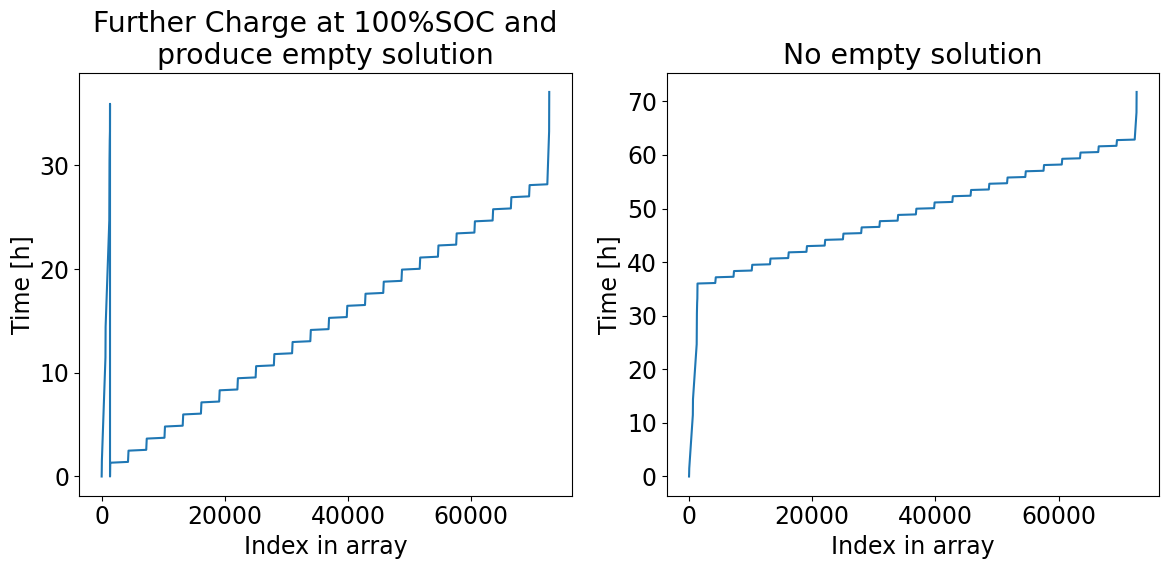

In [48]:
# don't delete!
from textwrap import wrap
print(len(sol_3.cycles))
print(len(sol_3.cycles[0].steps))
print(len(sol_3.cycles[1].steps))
print(sol_3.cycles[1].steps[1]["Time [h]"].entries)
fig, axs = plt.subplots(1,2, figsize=(12,6),tight_layout=True)
axs[0].plot(sol_3["Time [h]"].entries)
axs[1].plot(sol_2["Time [h]"].entries)
axs[0].set_title(
    "\n".join(wrap(
    "Further Charge at 100%SOC and produce empty solution",30)))
axs[1].set_title("No empty solution")
for i in range(2):
    axs[i].set_xlabel("Index in array")
    axs[i].set_ylabel("Time [h]")
    

26


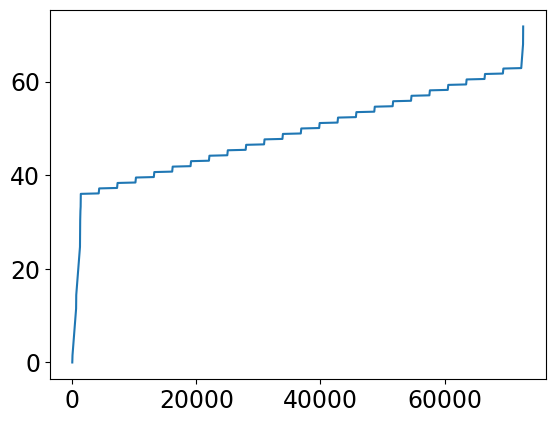

In [28]:
print(len(sol_2.cycles))
plt.plot(sol_2["Time [h]"].entries)

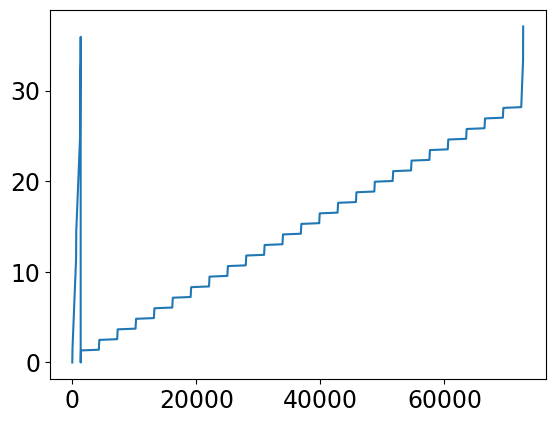

In [34]:
aa = sol_3["Time [h]"].entries
type(aa)
plt.plot(aa)

In [31]:
print(len(sol_3.cycles))
plt.plot(sol_3["Time [h]"].entries)

27


ValueError: Solution time vector must be strictly increasing

ValueError: Solution time vector must be strictly increasing

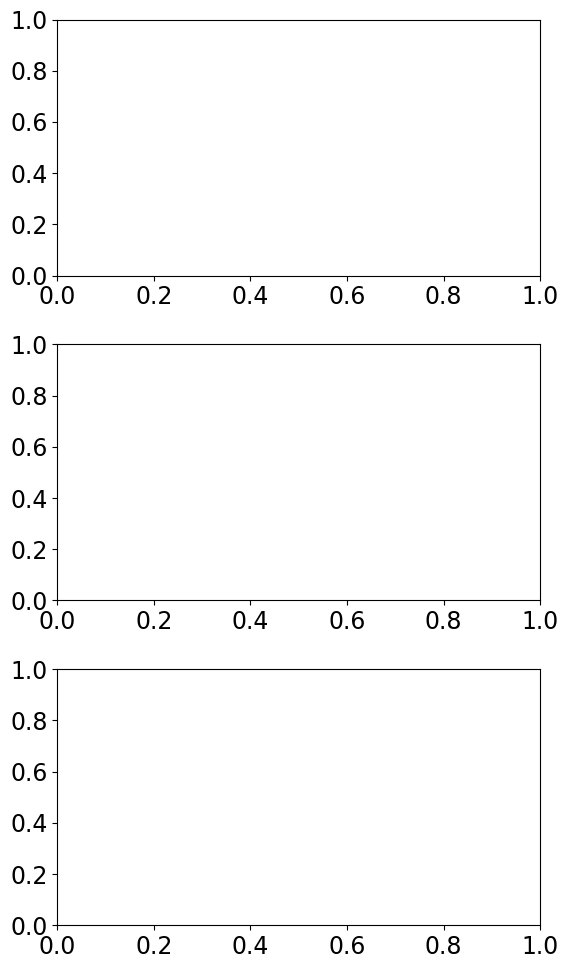

In [21]:
fig, axs = plt.subplots(3,1,figsize=(6,10),tight_layout=True) 
axs[0].plot(sol_1["Time [h]"].entries,sol_1["Terminal voltage [V]"].entries,'-o')
axs[1].plot(sol_1["Time [h]"].entries,sol_1["Current [A]"].entries,'-o')
axs[2].plot(
    sol_1["Time [h]"].entries,sol_1["Throughput capacity [A.h]"].entries - 
    sol_1["Throughput capacity [A.h]"].entries[0],'-o')